#### Business Analytics FHDW 2025
# Vorhersagen von Eigenschaften durch multiple lineare Regression
## am Beispiel von Gebrauchtwagenpreisen

Im Beispielszenario (wieder ein modifiziertes Beispiel aus Shmueli et al.) nimmt ein Autohandel gebrauchte Fahrzeuge in Zahlung. Er möchte natürlich wissen, wie viel das Auto potentiell noch wert ist. 

Zunächst importieren wir uns eine Reihe von Hilfsmitteln. Außerdem bauen wir uns unsere eigene kleine Funktion zur Zusammenfassung der Regressionsergebnisse. Falls *dmba* noch nicht installiert ist, holen Sie das mit dem Package Manager (*"PIP Installs Packages"*) von Python in der Anaconda Shell oder mit der Umleitung einer Zeile auf die Shell durch `!` nach:

In [1]:
import sys
# sys.executable adressiert die Python-Installation von Jupyter 
! {sys.executable} -m pip install dmba

   ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
   -------------- ------------------------- 4.2/11.8 MB 27.9 MB/s eta 0:00:01
   ------------------------------------- -- 11.0/11.8 MB 28.7 MB/s eta 0:00:01
   ---------------------------------------- 11.8/11.8 MB 27.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import math

from dmba import adjusted_r2_score, AIC_score, BIC_score

def regressionSummary(y_true, y_predicted):
    y_true = np.asarray(y_true)
    y_predicted = np.asarray(y_predicted)
    y_residuals = y_true - y_predicted
    metrics = [
        ('Summe Abweichungen', sum(y_residuals)),
        ('Summe absolute Abweichungen', sum(abs(y_residuals))),
        ('Mittlerer Fehler', sum(y_residuals) / len(y_residuals)),
        ('Mittlerer absoluter Fehler', sum(abs(y_residuals)) / len(y_residuals)),
        ('Wurzel des durchschnittlichen Fehlerquadrats', math.sqrt(mean_squared_error(y_true, y_predicted)))
    ]
    if all(yt != 0 for yt in y_true):
        metrics.extend([
            ('Mittlerer prozentualer Fehler', 100 * sum(y_residuals / y_true) / len(y_residuals)),
            ('Mittlerer absoluter prozentualer Fehler', 100 * sum(abs(y_residuals / y_true) / len(y_residuals))),
        ])
    maxlength = max(len(m[0]) for m in metrics)
    fmt1 = f'{{:>{maxlength}}} : {{:.4f}}'
    print('\nRegressionskennzahlen\n')
    for metric, value in metrics:
        print(fmt1.format(metric, value))

Wir lesen unsere Daten ein, reduzieren die auf die ersten 1000 Zeilen und wählen die für uns interessanten Spalten als Prädiktoren aus. Abhängige Zielvariable ist der Preis. 

In [3]:
car_df = pd.read_csv('Daten/ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

predictors = ['age_08_04', 
              'km', 
              'fuel_type', 
              'hp', 
              'met_color', 
              'automatic', 
              'cc', 
              'doors', 
              'quarterly_tax', 
              'weight']
outcome = 'price'

car_df[predictors]

,age_08_04,km,fuel_type,hp,met_color,automatic,cc,doors,quarterly_tax,weight
0,23,46986,Diesel,90,1,0,2000,3,210,1165
1,23,72937,Diesel,90,1,0,2000,3,210,1165
2,24,41711,Diesel,90,1,0,2000,3,210,1165
3,26,48000,Diesel,90,0,0,2000,3,210,1165
4,30,38500,Diesel,90,0,0,2000,3,210,1170
...,...,...,...,...,...,...,...,...,...,...
995,68,42750,Petrol,110,1,0,1600,3,69,1050
996,67,42102,Petrol,110,1,0,1600,5,85,1075
997,63,41586,Petrol,110,1,0,1600,5,19,1114
998,64,41200,Petrol,110,0,0,1600,5,85,1070


Kategorische Variablen wandeln wir in numerische, binäre Dummies um. Das betrifft im Falle unserer gewählten Prädiktoren die Treibstoffart. `drop_first=True` sorgt dafür, dass die erste resultierende Dummy-Variable verworfen wird, da sie durch ihre binären Werte vollständig mit den verknüpften bzw. weiteren aus der ursprünglichen kategorischen Variable generierten Dummies korreliert. Bzw. ist sie demnach schlicht redundant (wo die verbleibenden Dummies alle 0 sind, wäre der entfernte 1).

In [4]:
print(car_df.fuel_type.unique())
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
X

['Diesel' 'Petrol' 'CNG']


,age_08_04,km,hp,met_color,automatic,cc,doors,quarterly_tax,weight,fuel_type_Diesel,fuel_type_Petrol
0,23,46986,90,1,0,2000,3,210,1165,True,False
1,23,72937,90,1,0,2000,3,210,1165,True,False
2,24,41711,90,1,0,2000,3,210,1165,True,False
3,26,48000,90,0,0,2000,3,210,1165,True,False
4,30,38500,90,0,0,2000,3,210,1170,True,False
...,...,...,...,...,...,...,...,...,...,...,...
995,68,42750,110,1,0,1600,3,69,1050,False,True
996,67,42102,110,1,0,1600,5,85,1075,False,True
997,63,41586,110,1,0,1600,5,19,1114,False,True
998,64,41200,110,0,0,1600,5,85,1070,False,True


Mit `lmplot` aus *seaborn* können wir *scatterplots* mit einer Regressionsgeraden (`order=1`) generieren, die uns einen ersten Eindruck über die Verteilungen einzelner Prädiktoren liefern (der Bereich um die Gerade ist ein Konfidenzintervall). Wir setzen den Preis jeweils in Abhängigkeit von Alter, Kilometerstand und PS.

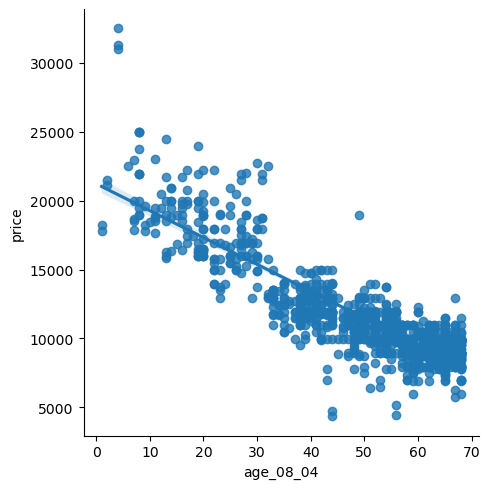

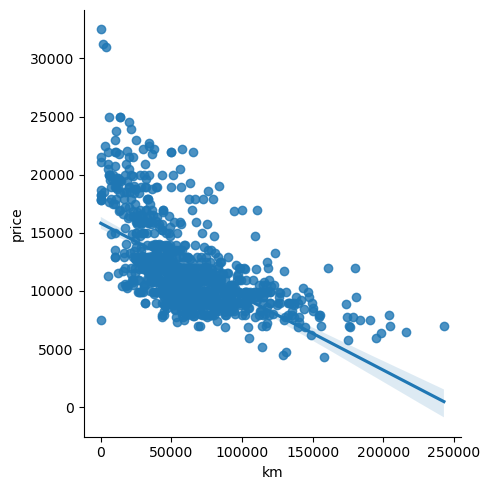

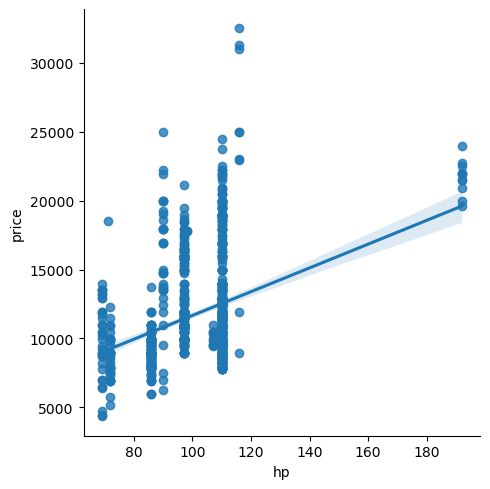

In [5]:
sns.lmplot(x ="age_08_04", y ="price", data = car_df, order = 1)
sns.lmplot(x ="km", y ="price", data = car_df, order = 1)
sns.lmplot(x ="hp", y ="price", data = car_df, order = 1)

Da wir eine bestmögliche *Vorhersage* erzielen möchten, teilen wir den Datensatz in eine Untermenge von 60% für Training und eine für Test bzw. Validierung von 40% auf. Die Datenpunkte wählt die Funktion `train_test_split` zufällig aus. Damit das Ergebnis trotzdem reproduzierbar bleibt, geben wir einen *seed* von 1 im Parameter `random_state` an.

In [6]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

Auf den Trainingsdatensätzen können wir nun die Regression durchführen.

In [7]:
car_lr = LinearRegression()
car_lr.fit(train_X, train_y)

print(pd.DataFrame({'Prediktor': X.columns, 'Koeffizient': car_lr.coef_}))
regressionSummary(train_y, car_lr.predict(train_X))

           Prediktor  Koeffizient
0          age_08_04  -140.748761
1                 km    -0.017840
2                 hp    36.103419
3          met_color    84.281830
4          automatic   416.781954
5                 cc     0.017737
6              doors   -50.657863
7      quarterly_tax    13.625325
8             weight    13.038711
9   fuel_type_Diesel  1066.464681
10  fuel_type_Petrol  2310.249543

Regressionskennzahlen

                          Summe Abweichungen : -0.0000
                 Summe absolute Abweichungen : 628144.2965
                            Mittlerer Fehler : -0.0000
                  Mittlerer absoluter Fehler : 1046.9072
Wurzel des durchschnittlichen Fehlerquadrats : 1400.5823
               Mittlerer prozentualer Fehler : -1.0223
     Mittlerer absoluter prozentualer Fehler : 9.2994


Das ist die zu erwartende Anpassung an den *Trainings*datensatz. Um die Prognosequalität unseres generierten Modells zu überprüfen, sagen wir die Preise der Fahrzeuge aus unserem Validierungsdatensatz voraus. Die Prädiktionen gleichen wir mit den echten Werten ab, indem wir die Differenzen bzw. Residuen ermitteln.

In [8]:
car_lr_prediction = car_lr.predict(valid_X)
residuals = valid_y-car_lr_prediction
prediction_results = pd.DataFrame({'Vorhersage': car_lr_prediction, 'Tatsächlich': valid_y, 'Residuum': residuals})
print(prediction_results.head(20))
regressionSummary(valid_y, car_lr_prediction)

       Vorhersage  Tatsächlich     Residuum
507  10607.333940        11500   892.666060
818   9272.705792         8950  -322.705792
452  10617.947808        11450   832.052192
368  13600.396275        11450 -2150.396275
242  12396.694660        11950  -446.694660
929   9496.498212         9995   498.501788
262  12480.063217        13500  1019.936783
810   8834.146068         7950  -884.146068
318  12183.361282         9900 -2283.361282
49   19206.965683        21950  2743.034317
446  10987.498309        11950   962.501691
142  18501.527375        19950  1448.472625
968   9914.690947         9950    35.309053
345  13827.299932        14950  1122.700068
971   7966.732543        10495  2528.267457
133  17185.242041        15950 -1235.242041
104  19952.658062        19450  -502.658062
6    16570.609280        16900   329.390720
600  13739.409113        11250 -2489.409113
496  11267.513740        11750   482.486260

Regressionskennzahlen

                          Summe Abweichungen : 41472

Die Bewertung der Resultate und ihre Qualität ist vom jeweiligen Anwendungsfall und seinen konkreten Anforderungen abhängig: Ist die Vorhersage genau genug? 

Daher noch einen Blick auf die Plausibilität des Modells, d. h. sind die Voraussetzungen überhaupt erfüllt? Ein *Tukey-Anscombe*-Diagramm aus den Prädiktionen und Residuen zeigt folgendes Bild. Erinnern sich sich an DAML - wie interpretieren Sie die Ergebnisse (wir möchten hier möglichst *homoskedastische* Daten)?

<Axes: xlabel='km', ylabel='Residuum'>

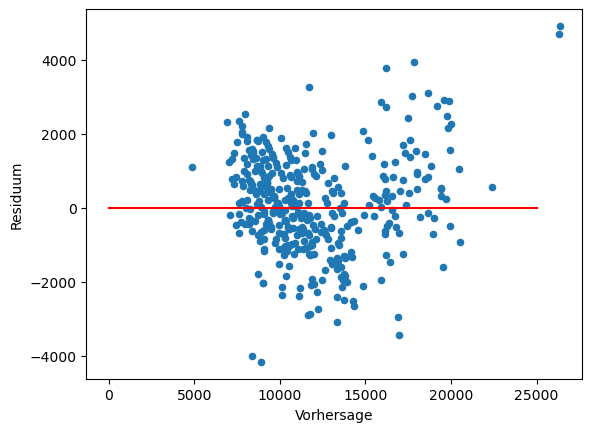

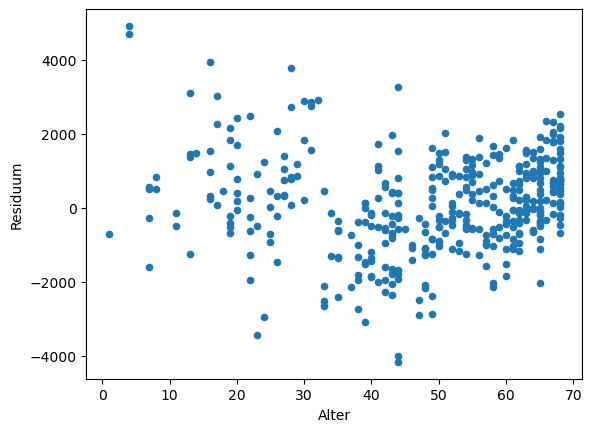

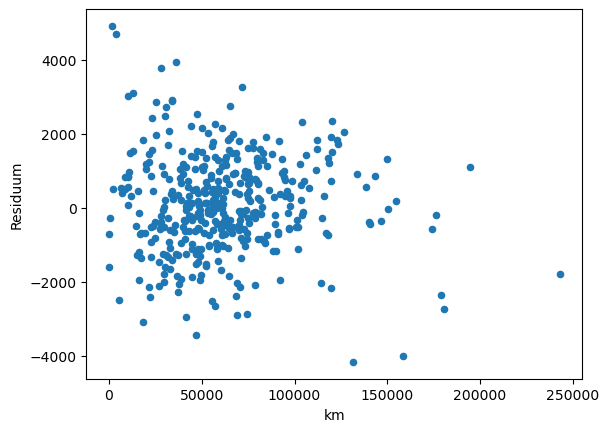

In [9]:
ta_plot = prediction_results.plot.scatter(x="Vorhersage", y="Residuum")
ta_plot.plot([0, 25000], [0, 0], color='red') # [Start x, Ende x], [Start y, Ende y]
scedasticity = pd.DataFrame({'Alter': valid_X["age_08_04"], 'km': valid_X["km"], 'Residuum': residuals})
scedasticity.plot.scatter(x="Alter", y="Residuum")
scedasticity.plot.scatter(x="km", y="Residuum")

Die Verteilung der Residuen zeigt folgende Form - Interpretation?

array([[<Axes: title={'center': 'Residuen'}>]], dtype=object)

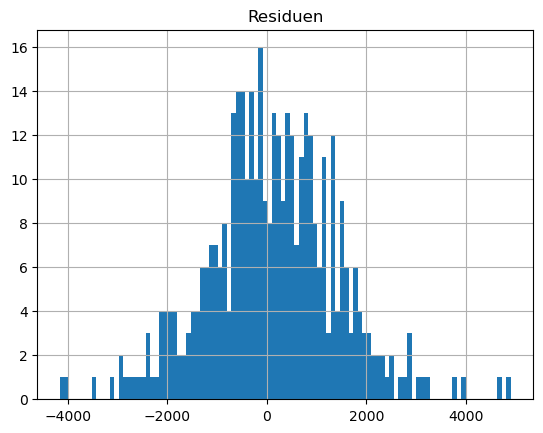

In [10]:
pd.DataFrame({'Residuen': residuals}).hist(bins=100)

## Aufgabe

1. Untersuchen Sie den Gebrauchtwagen-Datensatz auf redundante Variablen. Wenn Sie Variablen entfernen, versuchen Sie das sowohl aus dem Domänenkontext, als auch abstrakt anhand der Zahlen zu begründen.

2. Führen Sie mit dem reduzierten Datensatz eine Regression zur Vorhersage des Preises durch. Vergleichen Sie die Performance Ihres reduzierten Modells mit der des Modells mit dem vollen Umfang.

## Variablenauswahl für die lineare Regression

Die Reduzierung der Prädiktoren wie in der Übung ist mühsam und - spätestens bei hochdimensionalen Modellen - fehleranfällig. Da wir uns des Rechners bedienen, gibt es aber (neben PCA) weitere Möglichkeiten der Automatisierung.

Es gibt dazu eine Reihe von Kriterien zur Evaluierung und zum Vergleich von Modellen auf Grundlage von Metriken, die sich aus den Trainingsdaten berechnen lassen:

*Angepasstes* $R^2$ als $R^2_{adj}=1-\frac{n-1}{n-p-1}(1-R^2)$ mit $R^2=\frac{\sum{(\hat{y}_i-\overline{y})^2}}{\sum{(y_i-\overline{y})^2}}$

$R^2$ ist der Anteil der erklärten Variabilität in einem Modell. Die Anpassung nach $R^2_{adj}$ sorgt dafür, dass eine höhere Anzahl von Prädiktoren bestraft wird. Höhere Werte bedeuten eine bessere Anpassung des Modells.

*Akaike Information Criterion* $AIC=n\ln(SSE/n)+n(1+\ln(2\pi))+2(p+1)$

*Bayesian Information Criterion* $BIC=n\ln(SSE/n)+n(1+\ln(2\pi))+\ln(n)(p+1)$

$p$ ist die Anzahl der Prädiktoren, $n$ die Anzahl der Datensätze, $SSE=\sum_{i=1}^{n}{e^2_i}$ die Summe der Fehlerquadrate.

$AIC$ und $BIC$ schätzen den informationstheoretischen Vorhersagefehler eines Modells und bestrafen dabei auch höhere Parameteranzahlen. Niedrigere Werte bedeuten bessere Modelle. 

Die folgenden Implementierungen finden wir bei Shmueli et al. bzw. dem begleitenden Repo github.com/gedeck/dmba/blob/master/src/dmba/. Die Quellen sind hier teilweise leicht modifiziert.

### Erschöpfende Suche

Ein Ansatz "roher Gewalt" (*brute force*) besteht in der Auswertung aller möglichen Untermengen aus Prädiktoren. Für jede Untermenge wird die Modellperformance geprüft, die mit dem besten Ergebnis wird für die Vorhersagen genutzt.

Die nachfolgende Funktion untersucht also diesen Raum aller möglichen Lösungen und gibt für jede Anzahl von Prädiktoren die Untermenge mit dem besten $R^2_{adj}$-Wert zurück.

In [11]:
import itertools

def train_model_exhaustive(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model

def score_model_exhaustive(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    return -adjusted_r2_score(train_y, pred_y, model)

def exhaustive_search(variables, train_model, score_model):    
    """
    Input:
        variables: complete list of variables to consider in model building
        train_model: function that returns a fitted model for a given set of variables
        score_model: function that returns the score of a model; better models have lower scores
    Returns:
        List of best subset models for increasing number of variables
    """
    # create models of increasing size and determine the best models in each case
    result = []
    for nvariables in range(1, len(variables) + 1):
        best_subset = None
        best_score = None
        best_model = None
        for subset in itertools.combinations(variables, nvariables):
            subset = list(subset)
            subset_model = train_model(subset)
            subset_score = score_model(subset_model, subset)
            if best_subset is None or best_score > subset_score:
                best_subset = subset
                best_score = subset_score
                best_model = subset_model
        result.append({
            'n': nvariables,
            'variables': best_subset,
            'score': best_score,
            'model': best_model,
        })
    return result

In [12]:
all_variables = train_X.columns
results = exhaustive_search(all_variables, train_model_exhaustive, score_model_exhaustive)

data = []
for result in results:
    model = result['model']
    variables = list(result['variables'])
    aic = AIC_score(train_y, model.predict(train_X[variables]), model)
    d = {'n':result['n'], 'r2adj':-result['score'], 'AIC':aic}
    d.update({var: var in result['variables'] for var in all_variables})
    data.append(d)

pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(all_variables)))

,n,r2adj,AIC,age_08_04,automatic,cc,doors,fuel_type_Diesel,fuel_type_Petrol,hp,km,met_color,quarterly_tax,weight
0,1,0.767901,10689.712094,True,False,False,False,False,False,False,False,False,False,False
1,2,0.801160,10597.910645,True,False,False,False,False,False,True,False,False,False,False
2,3,0.829659,10506.084235,True,False,False,False,False,False,True,False,False,False,True
3,4,0.846357,10445.174820,True,False,False,False,False,False,True,True,False,False,True
4,5,0.849044,10435.578836,True,False,False,False,False,False,True,True,False,True,True
5,6,0.853172,10419.932278,True,False,False,False,False,True,True,True,False,True,True
6,7,0.853860,10418.104025,True,False,False,False,True,True,True,True,False,True,True
7,8,0.854297,10417.290103,True,True,False,False,True,True,True,True,False,True,True
8,9,0.854172,10418.789079,True,True,False,True,True,True,True,True,False,True,True
9,10,0.854036,10420.330800,True,True,False,True,True,True,True,True,True,True,True


### Auswahl von Untermengen

Bei einer großen Anzahl an Prädiktoren stößt die erschöpfende Suche auch bei leistungsfähigen Infrastrukturen irgendwann an Grenzen. Ein Kompromiss, der entsprechend nicht immer zum optimalen Ergebnis führt, besteht in der Untersuchung nur von Teilmengen des gesamten Lösungsraums. Diese Teilmengen werden iterativ nach unterschiedlichen Ansätzen gebildet.

Die **Forward Selection** startet mit einer leeren Prädiktorenmenge und fügt in jedem Schritt einen Prädiktor hinzu. Es wird der ausgewählt, der - zusätzlich zu den schon vorhandenen - den größten Beitrag zur Performance des Modells leistet. Die Iteration hält an, wenn der zusätzliche Beitrag nicht mehr statistisch signifikant ist. Der Algorithmus berücksichtigt dabei entsprechend nicht alle Kombinationen.

In [13]:
def train_model_forward_selection(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model_forward_selection(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()]*len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

def forward_selection(variables, train_model, score_model, verbose=True):
    """ 
    Input:
        variables: complete list of variables to consider in model building
        train_model: function that returns a fitted model for a given set of variables
        score_model: function that returns the score of a model; better models have lower scores
    Returns:
        (best_model, best_variables)
    """
    # we start with a model that contains no variables
    best_variables = []
    best_model = train_model(best_variables)
    best_score = score_model(best_model, best_variables)
    if verbose:
        print('Variables: ' + ', '.join(variables))
        print(f'Start: score={best_score:.2f}, constant')
    while True:
        step = [(best_score, None, best_model)]
        for addVar in variables:
            if addVar in best_variables:
                continue
            step_var = list(best_variables)
            step_var.append(addVar)
            step_model = train_model(step_var)
            step_score = score_model(step_model, step_var)
            step.append((step_score, addVar, step_model))
        step.sort(key=lambda x: x[0])

        # the first entry in step is now the model that improved most
        best_score, added_step, best_model = step[0]
        if verbose:
            print(f'Step: score={best_score:.2f}, add {added_step}')
        if added_step is None:
            # stop here, as adding more variables is detrimental to performance
            break
        best_variables.append(added_step)
    return best_model, best_variables

In [14]:
best_model, best_variables = forward_selection(train_X.columns, 
                                               train_model_forward_selection,
                                               score_model_forward_selection,
                                               verbose=True)
print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: age_08_04, km, hp, met_color, automatic, cc, doors, quarterly_tax, weight, fuel_type_Diesel, fuel_type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add age_08_04
Step: score=10597.91, add hp
Step: score=10506.08, add weight
Step: score=10445.17, add km
Step: score=10435.58, add quarterly_tax
Step: score=10419.93, add fuel_type_Petrol
Step: score=10418.10, add fuel_type_Diesel
Step: score=10417.29, add automatic
Step: score=10417.29, add None
['age_08_04', 'hp', 'weight', 'km', 'quarterly_tax', 'fuel_type_Petrol', 'fuel_type_Diesel', 'automatic']

Regressionskennzahlen

                          Summe Abweichungen : 41321.8085
                 Summe absolute Abweichungen : 406755.0186
                            Mittlerer Fehler : 103.3045
                  Mittlerer absoluter Fehler : 1016.8875
Wurzel des durchschnittlichen Fehlerquadrats : 1314.4844
               Mittlerer prozentualer Fehler : -0.2700
     Mittlerer absoluter prozentualer Fehler : 8.9984


Die **Backward Elimination** startet mit der Menge aller Prädiktoren und reduziert in darauf folgenden Schritten die Menge jeweils um den Prädiktor mit dem geringsten Nutzen für die Performance des Modells gemäß statistischer Signifikanz. Der Algorithmus stoppt, wenn alle in der Untermenge enthaltenen Prädiktoren einen statistisch signifikanten Beitrag leisten. Nachteilig ist hier u. a., dass die ersten Modelle mit allen bzw. vielen Prädiktoren sehr aufwändig zu prüfen sein können.

In [15]:
def train_model_backward_elimination(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model_backward_elimination(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)  

def backward_elimination(variables, train_model, score_model, verbose=False):
    """ 
    Input:
        variables: complete list of variables to consider in model building
        train_model: function that returns a fitted model for a given set of variables
        score_model: function that returns the score of a model; better models have lower scores
    Returns:
        (best_model, best_variables)
    """
    # we start with a model that contains all variables
    best_variables = list(variables)
    best_model = train_model(best_variables)
    best_score = score_model(best_model, best_variables)
    if verbose:
        print('Variables: ' + ', '.join(variables))
        print(f'Start: score={best_score:.2f}')

    while len(best_variables) > 1:
        step = [(best_score, None, best_model)]
        for removeVar in best_variables:
            step_var = list(best_variables)
            step_var.remove(removeVar)
            step_model = train_model(step_var)
            step_score = score_model(step_model, step_var)
            step.append((step_score, removeVar, step_model))

        # sort by ascending score
        step.sort(key=lambda x: x[0])

        # the first entry is the model with the lowest score
        best_score, removed_step, best_model = step[0]
        if verbose:
            print(f'Step: score={best_score:.2f}, remove {removed_step}')
        if removed_step is None:
            # step here, as removing more variables is detrimental to performance
            break
        best_variables.remove(removed_step)
    return best_model, best_variables

In [16]:
all_variables = train_X.columns
best_model, best_variables = backward_elimination(all_variables, 
                                                  train_model_backward_elimination, 
                                                  score_model_backward_elimination,
                                                  verbose=True)

print(best_variables)

Variables: age_08_04, km, hp, met_color, automatic, cc, doors, quarterly_tax, weight, fuel_type_Diesel, fuel_type_Petrol
Start: score=10422.30
Step: score=10420.33, remove cc
Step: score=10418.79, remove met_color
Step: score=10417.29, remove doors
Step: score=10417.29, remove None
['age_08_04', 'km', 'hp', 'automatic', 'quarterly_tax', 'weight', 'fuel_type_Diesel', 'fuel_type_Petrol']


Die **Stepwise Selection** arbeitet wie die *Forward Selection* oben, schließt aber in jedem Schritt wie die *Backward Elimination* Prädiktoren aus, die keinen statistisch signifikanten Beitrag leisten.

In [17]:
def stepwise_selection(variables, train_model, score_model, direction='both', verbose=True):
    """ 
    Input:
        variables: complete list of variables to consider in model building
        train_model: function that returns a fitted model for a given set of variables
        score_model: function that returns the score of a model; better models have lower scores
        direction: use it to limit stepwise selection to either 'forward' or 'backward'
    Returns:
        (best_model, best_variables)
    """
    FORWARD = 'forward'
    BACKWARD = 'backward'
    directions = [FORWARD, BACKWARD]
    if direction.lower() == FORWARD:
        directions = [FORWARD]
    if direction.lower() == BACKWARD:
        directions = [BACKWARD]

    # we start with a model that contains no variables
    best_variables = [] if 'forward' in directions else list(variables)
    best_model = train_model(best_variables)
    best_score = score_model(best_model, best_variables)
    if verbose:
        print('Variables: ' + ', '.join(variables))
        print(f'Start: score={best_score:.2f}, constant')

    while True:
        step = [(best_score, None, best_model, 'unchanged')]
        if FORWARD in directions:
            for variable in variables:
                if variable in best_variables:
                    continue
                step_var = list(best_variables)
                step_var.append(variable)
                step_model = train_model(step_var)
                step_score = score_model(step_model, step_var)
                step.append((step_score, variable, step_model, 'add'))

        if 'backward' in directions:
            for variable in best_variables:
                step_var = list(best_variables)
                step_var.remove(variable)
                step_model = train_model(step_var)
                step_score = score_model(step_model, step_var)
                step.append((step_score, variable, step_model, 'remove'))

        # sort by ascending score
        step.sort(key=lambda x: x[0])

        # the first entry is the model with the lowest score
        best_score, chosen_variable, best_model, direction = step[0]
        if verbose:
            print(f'Step: score={best_score:.2f}, {direction} {chosen_variable}')
        if chosen_variable is None:
            # step here, as adding or removing more variables is detrimental to performance
            break
        if direction == 'add':
            best_variables.append(chosen_variable)
        else:
            best_variables.remove(chosen_variable)
    return best_model, best_variables

In [18]:
best_model, best_variables = stepwise_selection(train_X.columns, 
                                                train_model_forward_selection,
                                                score_model_forward_selection,
                                                verbose=True)
print(best_variables)

Variables: age_08_04, km, hp, met_color, automatic, cc, doors, quarterly_tax, weight, fuel_type_Diesel, fuel_type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add age_08_04
Step: score=10597.91, add hp
Step: score=10506.08, add weight
Step: score=10445.17, add km
Step: score=10435.58, add quarterly_tax
Step: score=10419.93, add fuel_type_Petrol
Step: score=10418.10, add fuel_type_Diesel
Step: score=10417.29, add automatic
Step: score=10417.29, unchanged None
['age_08_04', 'hp', 'weight', 'km', 'quarterly_tax', 'fuel_type_Petrol', 'fuel_type_Diesel', 'automatic']
